$\Huge Constrained$ $\hspace{0.1cm}$ $\Huge Internal$ $\hspace{0.1cm}$ $\Huge Linear$ $\hspace{0.1cm}$ $\Huge Combination$ $\hspace{0.1cm}$ $\Huge (CILC)$ $\hspace{0.1cm}$  $\Huge code$ $\hspace{0.1cm}$ $\Huge :$ 

# TO DO : 

1. Implement gaussian fitting and removal of the mean
2. Implement bandpass correction
3. Implement weight maps when no tessalation 
4. Implement more than two mixing vectors 

# Modules : 

In [1]:
import healpy as hp
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
import matplotlib.cm as cm
import matplotlib.pyplot as plt 
from astropy.cosmology import FlatLambdaCDM
from astropy import constants as cst
import sz_tools as sz 
import pymaster as PyM
import fMaps as fM
import fbasic as fb
import ccatp_sky_model as sky
import CILC as CILC

# Physics : 

In [2]:
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.7255)
T_CMB = cosmo.Tcmb0.si.value #
k_B = cst.k_B.value
h = cst.h.value
c = cst.c.value
sig_T = cst.sigma_T.value #Thomson cross section in m2 
me = cst.m_e.value #Electron mass in kg 
Te = 5.930155e9 #Electron temperature in K

# Code : 

In [3]:
data_path = '/users/mcharmetant/data1/Data/Planck_AllSky_maps/'
file_P1 = 'HFI_SkyMap_'
file_P2 = '_2048_R2.02_full'
dic_freq = {0:100,1:143,2:217,3:353,4:545,5:857}
dic_reso={0:9.66, 1:7.27, 2:5.01, 3:4.86, 4:4.84, 5:4.63}

###### About smoothing : 

When performing ILC, or CILC on multiple maps of different frequencies. All the maps at different frequencies have differents beam resolution. To perform ILC on them we need them all to be at the same resolution. In order to do that we have to apply them a gaussian filter.

For exemple for Planck data : 

We are going to put all the maps at the lowest map resolution which is the one of 100 GHz. We know that for the lowest resoution map, the gaussian has a FWHM = 9.66', and all the other maps, they have a gaussian with a given FWHM = $reso_{others}$.  Therefore the FWHM is given by : $FWHM = \sqrt{9.66^{2}-reso_{others}^{2}}$. 

It is easy to demonstrate that this is true for a Gaussian beam. We have that be beam is : 

$\sqrt{e^{\frac{-l^{2}r_{a}^{2}}{8ln2}}}$ with $r_{a}$ the actual resolution. 

$\sqrt{e^{\frac{-l^{2}r_{a}^{2}}{8ln2}}}\sqrt{e^{\frac{-l^{2}\sqrt{r_{w}^{2}-r_{a}^{2}}^{2}}{8ln2}}}$ $\Rightarrow$ $\sqrt{e^{\frac{-l^{2}r_{w}^{2}}{8ln2}}}$ where $r_{w}$ is the desired resolution.

The resolutions are given in arcmin. However, the healpy smoothing function used for smoothing the map take in a FWHM in radians, therefore we need to convert it by multiplying by $\pi / (180\times 60)$. Because 1 arcmin is 1/60 of a degree and 1 degree is $\pi/180$ radians. 

In [4]:
def smooth2reso(wt_reso,ori_reso,Hmap): 
    
    """
    Function which smooth a HEALPy map, using a gaussian, to desired resolution taking into account its original resultion
    given by ori_reso. 

    Parameters
    ----------
     
    wt_reso : float
        desired resolutions of the map in arcmin. 
    ori_reso : float
        original resolution of the map in arcmin. 
    Hmap : array
        Map we want to smooth.         
        
    Returns
    -------
    array
        The smoothed map.

    """
                  
    FWHM_i = np.sqrt(wt_reso**2 - ori_reso**2) 
    FWHM_f = FWHM_i/ 60 * np.pi/180 
    Fmap = hp.smoothing(Hmap, fwhm=FWHM_f, beam_window=None, pol=False, iter=0, lmax=None,mmax=None)
    
    return(Fmap)

###### About merging : 

In order to compute the covariance matrix of all the multi-frequency maps to compute the ILC coefficients we need to merge all the single array maps into a big matrix containing all the maps. Where each column is one frequency map. We smooth them all to the same resolution in the process. 

In [5]:
def mergemaps(maps_array,wt_reso,dic_reso): 
    
    """
    Function which merge a list of map into a single matrix.  

    Parameters
    ----------
    
    maps_array ; array 
        Array containing all the healpy maps we want to perform the ILC on. Should be in RING ordering. 
    wt_reso : float
        desired resolutions of the maps. 
    dic_reso : dictionary
        dictionary containing the list of all the resolutions of each of the maps.
        
    Returns
    -------
    ndarray
        Containing in each of its column a map. 

    """
    
    for i in range(len(maps_array)):
            
        Hmap = smooth2reso(wt_reso=wt_reso,ori_reso=dic_reso[i],Hmap=maps_array[i])
        
        if i == 0:
        
            stacked = [Hmap]
            
        else: 
    
            stacked = np.concatenate((stacked,[Hmap]),axis=0)
    
    return stacked

###### Gausian function : 

The Gaussian is defined by the expression : 

$Ae^{\frac{-(x-\mu)^{2}}{2\sigma ^{2}}}$ Where $A$ is the normalisation, $\mu$ the mean and $\sigma$ the dispersion.

In [6]:
def gauss(x,a,mu,sigma):

    """
    Gaussian function 

    Parameters
    ----------
    x : array_like
        Data entering the Gaussian function.
    a :  array_like
        Normalization factor of the Gaussian. 
    mu : float
        Mean value of the Gaussian.
    sigma : float
        Dispersion of the Gaussian.
        
    Returns
    -------
    str
        Return the Gaussian function. 

    """
    
    return a * np.exp( -(x-mu)**2 / (2*sigma**2) ) 

In [7]:
def gaussian_fit(Hmap,bin_nb): 
    
    """
    Function which display the histogram of the imput data. 

    Parameters
    ----------
    data_file : str
        Name of the FITS file containing the data. 
    data_path : str
        Path were the data of the maps are stored. 
    name_object : str
        Name of the data we are ploting. For exemple : y map of Coma Cluster.
    pictures_path : str
        Path where we are going to save the pictures. 
    x_axis : str 
        Unit of the data we displaying. 
    bin_nb : int 
        Number of bin desired for the histogram.
        
    Returns
    -------
    str
        Tell us where the function stored the image.

    """
     
    mu = np.mean(Hmap) #Compute the mean of the datas 
    sig = np.std(Hmap) #Compute the standard deviation of the datas 
    data_cut = [] 
    
    # Cut the extremes values of the datas we are going to work with 
    for i in range(len(Hmap)):
        if mu - 2 * sig < Hmap[i] < mu + 2 * sig: 
            data_cut.append(Hmap[i])
    
    
    histo, bins = np.histogram(data_cut, bins=bin_nb) #Compute the Histogram, in histo as all the values of the data by bins
    x = 0.5*(bins[1:]+bins[0:-1])# take the middle of each bin 
    
    #Gaussian FITS :   
    popt,pcov = curve_fit(gauss,x,histo,p0=(np.max(histo), np.mean(data_cut), np.std(data_cut)),sigma = np.sqrt(histo+1)) #P0 is the initial guess, to guide the fit
    plt.plot(x,gauss(x,*popt))
    plt.show()
    
    return popt[1]

    

###### About merging in field : 

In order to copute the ILC coefficient one need to compute the covariance matrix of the multi-frequency maps. In order to do that one need to merge all the HEALPy array into a single matrix. When performing full-sky ILC, it brings a better results if the ILC is perform first on sky patches and then the full-sky map is reactrating by addin back all the patches together. This is because the microwave component of the sky are very different close to th galactic plane than far away from it for exemple. A full sky ILC can be perform with separating the sky into small patches but in that case the ILC with will try to minize galactic foreground everywhere even where there is none, therefore increasing the overall noise of the final ILC produced map. 

To avoid that we are going to separate each frequency map into small patches, using the HEALPy tessalation. When $N_{side} = 4$, the sky is separated into $N_{pix} = 12\times N_{side}^{2}= 12\times 4^{2}= 192$ big pixels. 

So If we take Planks maps with $N_{side} = 2048$ and tessalate them using $N_{side} = 4$, we will obtain 192 patches, each containing  : $N_{pix}/N_{patches} = 12\times 2048^{2}/192 = 262144$ pixels.

Therefore we create a matrix pf the size (number pixels/field, number of field, number of frequencies) here (262144,192,6) and we will compute one covariance matrix for each fields of all the frequencies maps, so for Planck data and its 6 frequencies : (262144,0,6); (262144,1,6); ... ; (262144,192,6) 

In [37]:
def map2fields(maps_array,It,nfields,wt_reso,dic_reso,median,gauss,mask,dic_freq): 
    
    """
    Function which read maps at different frequencies, smooth them to a desired resolution and merge them 
    into a big matrix composed of each pixel for each healpy field and for each frequency. 

    Parameters
    ----------
    
    maps_array : array 
        Containing all the healpy maps we want to perform the ILC on should be in RING ordering.
    It : int 
        Number of pixels per field.
    nfields : int 
        Number of fields. 
    wt_reso : float
        Desired resolutions of the maps in arcmin. 
    dic_reso : dictonary 
        Dictonary containing all 
    median : bool 
        If True remove the median of each field. Otherwise fit a Gaussian to the pixel histogram 
        and remove the bias of each field.
         
    Returns
    -------
    ndarray
        Containing in the row the number of pixels in a field, each column is a field and the tird dimesion
        is the number of frequencies.  

    """
        
    cube = np.empty([int(It),int(nfields),int(len(dic_freq))])
    
    if mask is not None : 
        mask = hp.pixelfunc.reorder(mask, r2n = True)
    
    for i in range(len(maps_array)):
                 
        Fmap = smooth2reso(wt_reso=wt_reso,ori_reso=dic_reso[i],Hmap=maps_array[i])
        
        Fmap = hp.pixelfunc.reorder(Fmap, r2n = True)
        
        if mask is not None: 
            
            Fmap *= mask 
        
        else: 
            
            Fmap = Fmap 
        
        k=0
        for j in range(0,len(Fmap),It):  
                    
                cube[0:It,k,i]+= Fmap[j:j+It]
                k = k+1   
                    
    return cube 

###### About computing the covariance matrix : 

We compute the covariance matrix using the numpy function when the maps have no mask. When part of the maps are masked the need to compute the covariance matrix only with the non-masked pixels of each field. We use the np.where function to select only the non masked pixels and compute the covariance matrix with them only. 

In [9]:
def covcorr_matrix(data,rowvar,mask,dic_freq):
    
    """
    Function which compute the covariance matrix and the correlation matrix.  

    Parameters
    ----------
    
    data : array
        Array containing the data we want to take the covariance matrix of. 
    rowvar : bool
        If rowvar is True (default), then each row represents a variable, with observations in the columns. 
        Otherwise, the relationship is transposed: each column represents a variable, while the rows contain
        observations.
    mask : bool
        If True compute the covariance matrix only on the non-masked pixels. Otherwise on all the array.
    dic_freq : dictonary 
        Dictonary containing all the frequencies we want to compute the covariance matrix on.
        
    Returns
    -------
    tuple
        containing [0] : the covariance matrix [1] : the correlation matrix

    """
    
    #Compute the covariance matrix : 
    if mask is not None: 
        for i in range(len(dic_freq)):
            not_masked = np.where(data[:,i] != 0)[0]
        data = data[not_masked]
        
    cov_matrix = np.cov(data,y = None, rowvar = rowvar) #Compute the covariance matrix 

    #Compute the correlation matrix : 
    corr_matrix = np.corrcoef(data, y=None, rowvar=rowvar) #Compute the correlation matrix 
    
    return (cov_matrix,corr_matrix)

###### About tSZ spectrum : 

With the ILC and CILC we are using the spectral shape of an effect of interest. By that I mean we want to quantify the spectral difference made by the effect with respect to the CMB monopole. For the thermal SZ effect this take this shape in Intensity (Mjy/sr) : 

$\Delta I_{\nu}=I_{0}y\frac{x^{4}e^{x}}{(e^{x}-1)^{2}}(x\frac{e^{x}+1}{e^{x}-1}-4)$ where $x=\frac{h\nu}{k_{B}T_{CMB}}$

To convert it to $K_{CMB}$ units we mutiply we above equation by : 

$\frac{\Delta I_{\nu}}{I_{0}} \times T_{CMB}\frac{(e^{x_{\nu}}-1)^{2}}{x_{\nu}^{4}e^{x_{\nu}}}$

In the first approximation we take $y=1$, the usual value for a cluster is rather $y=10^{-4}$

We want to diplay tSZ, we have : 

$\Delta I_{tSZ}=I_{0}yf(x(\nu))h(x(\nu))=I_{0}y\frac{x(\nu)^{4}e ^{x(\nu)}}{(e^{x(\nu)}-1)^{2}}(x(\nu)\frac{e^{x(\nu)}+1}{e^{x(\nu)}-1}-4)$    with $x(\nu)=\frac{h\nu}{k_{B}T_{CMB}}$ and $y=\frac{\sigma _{T}}{m_{e}c^{2}}\int P_{e}dl$ where $P_{e}=n_{e}k_{B}T_{e}$



In [10]:
def D_I_tSZ(x,y,MJy=False):
    
    """
    Function which compute the tSZ spectral shape. 

    Parameters
    ----------
    
    x : array
        Frequency range over which the tSZ spectral shape will be computed. 
    y : float
        Value of the Compton-y parameter assumed here. 
    MJy : bool
        If False display the spectral changed in K_CMB units. If True display it in MJy/sr units. 
        
    Returns
    -------
    array
        Array contaning the Variarion of intensity produced by tSZ over the fequencies. 

    """
 
    #Compute Delta I : 
    I_0 = (2*(cst.k_B.value*T_CMB)**3)/(cst.h.value*cst.c.value)**2  
    I_0 = I_0*1e20
    x_nu = np.array((cst.h.value*x)/(cst.k_B.value*T_CMB))    
    Delta_I = np.array(I_0*y*(x_nu**4)*(np.exp(x_nu)/(np.exp(x_nu)-1)**2)*((x_nu*(np.exp(x_nu)+1)/(np.exp(x_nu)-1))-4))
    
    if MJy == False:
        
        Delta_I = Delta_I * (T_CMB/I_0) * ((np.exp(x_nu)-1)**2) / (x_nu**4*np.exp(x_nu)) #Convert to K_CMB units
        
    
    #Give feedback to the operator : 
    print("Delta I as been computed,I_0 =", I_0)
    
    return   Delta_I

###### Dsiplay the shape of the tSZ spectrum :

Delta I as been computed,I_0 = 270.0626342365431


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


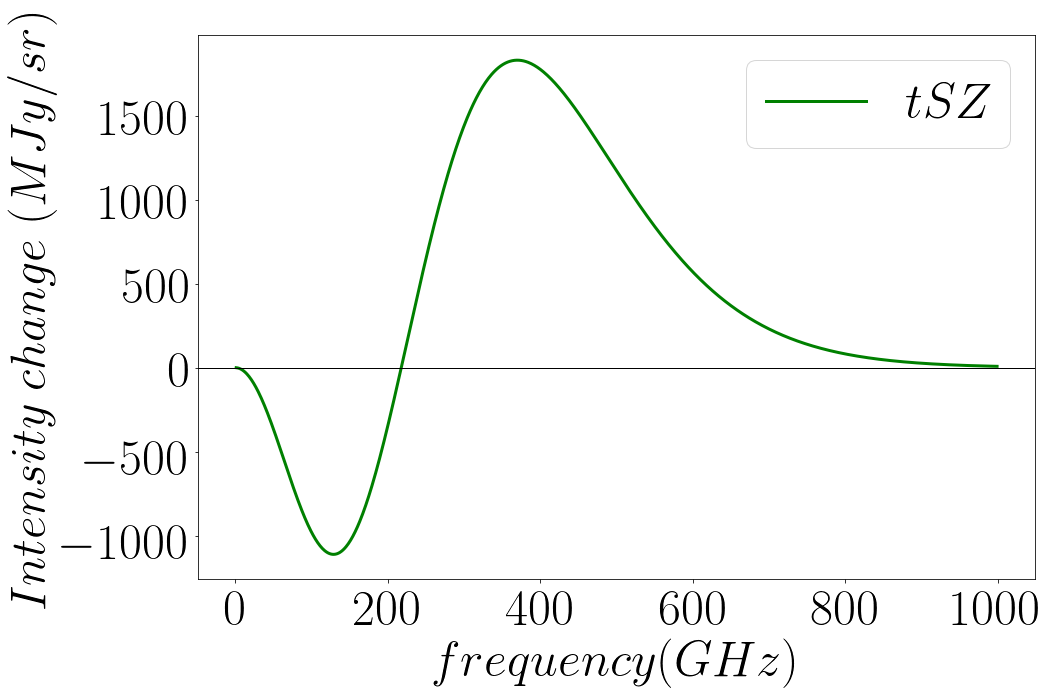

In [12]:
A=np.arange(1,1000)
B = D_I_tSZ(x=A*1e9,y=1,MJy=True)
font = 50

fig, ax = plt.subplots()

ax.plot(A,B,color='g',linewidth=3.0,label='$tSZ$') 

ax.axhline(color='black', lw=1)
#ax.set_title(fig_title,fontsize=28)
ax.set_xlabel('$frequency (GHz)$',fontsize=font)
ax.set_ylabel('$Intensity$ $change$ $(MJy/sr)$',fontsize=font) 
plt.xticks(fontsize=font)
plt.yticks(fontsize=font)
plt.legend(fontsize=font)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

###### About the CMB spectrum : 

ILC and CILC methods are based on the knowledge of the intensity variation (in Mjy/sr) or temperature variation ($K_{CMB}$) with respect to the CMB black body spectrum at 2.73K, given by a Planckian : 

$B_{\nu}(T)=\frac{2h\nu^{3}}{c^{2}}\frac{1}{e^{\frac{h\nu}{k_{B}T}}-1}$

Therefore, when trying to reconstruct a CMB map using the ILC, we want to look atthe variations of temperature or intensity compared to this planckian.

In temperature units, the variation the CMB compare to its monopole at 2.73K is a contsant, therefore, we can take that the mixing vector is [1,....,1]. In Mjy/sr, the variation is the first temperature derivate of its spectrum : 

$\frac{\partial B(\nu,T)}{\partial T}(T=T_{CMB})=\frac{2k_{B}^{3}T_{CMB}^{2}}{(hc)^{2}}\frac{x^{4}e^{x}}{(e^{x}-1)^{2}}$

The exact derivation of that is : 

A black body spectrum is given by : $I_{\nu}=B_{\nu}(T)$ it is only dependent of the temperature. 

$\Delta I_{\nu}=B_{\nu}(T+\Delta T)-B_{\nu}(T)$

$\Delta I_{\nu}=\frac{\partial B_{\nu}(T)}{\partial T}\Delta T$

In [13]:
def D_I_CMB(x):
    
    """
    Function which compute the CMB spectral shape. 

    Parameters
    ----------
    
    x : array
        Frequency range over which the CMB spectral shape will be computed. 
        
    Returns
    -------
    array
        Array contaning the variarion of intensity produced by CMB over the fequencies. 

    """ 
        
    #Compute Delta I :  
    x_nu = np.array((cst.h.value*x)/(cst.k_B.value*T_CMB)) 
    A=np.array((2*cst.h.value*x**3)/(cst.c.value**2))  
    Delta_I= A * (x_nu/T_CMB)* np.exp(x_nu) / ((np.exp(x_nu)-1)**2) *1e20
    
    #Give feedback to the operator : 
    print("Delta I as been computed ")
    
    return   Delta_I

###### Spectrum of the CIB : 

Similarly for CIB, we implement the first temperature derivative of the intensity spectrum, which is a modified blackbody : 

$I_{CIB}(\nu)=A_{CIB}(\frac{\nu}{\nu _{0}})^{\beta + 3}\frac{e^{\frac{h\nu _{0}}{k_{B}T}}-1}{e^{\frac{h\nu }{k_{B}T}}-1}$ 

Its SED in $K_{CMB}$ units is given by $I_{CIB}=\frac{\nu ^{\beta +3}}{e^{\frac{h\nu}{k_{B}T_{CIB}-1}}}(\frac{\partial B(\nu,T)}{\partial T})^{-1}(T=T_{CMB})$ where $\beta = 1,2$ and $T_{CIB}=24K$

with $(\frac{\partial B(\nu,T)}{\partial T})^{-1}(T=T_{CMB})= T_{CMB}\frac{(e^{x}-1)^{2}}{x^{4}e^{x}}$ 

In [14]:
def D_I_CIB(x,A=1,b=1.2,f_0=350e9,T_CIB=24,MJy=False):
    
    """
    Function which compute the CIB spectral shape. 

    Parameters
    ----------
    
    x : array
        Frequency range over which the CIB spectral shape will be computed. 
    A : float 
        Normalisation of the CIB power spectrum. By default A=1.
    b : float 
        By default b=1.2
    T_CIB : float
        By default T_CIB=24 Kelvin. 
    MJy : bool
        If False display the spectral changed in K_CMB units. If True display it in MJy/sr units.
        
    Returns
    -------
    array
        Array contaning the Variarion of intensity produced by CMB over the fequencies. 

    """
    
    #Compute Delta I :  
    I_0 = (2*(cst.k_B.value*T_CMB)**3)/(cst.h.value*cst.c.value)**2  
    I_0 = I_0*1e20
    x_nu = np.array((cst.h.value*x)/(cst.k_B.value*T_CMB)) 
    Delta_I = A * (x/f_0)**(3.+b) * (np.exp(cst.h.value*f_0/cst.k_B.value/T_CIB)-1) / (np.exp(cst.h.value*x/cst.k_B.value/T_CIB)-1)
    
    if MJy == False: 
        
        Delta_I = Delta_I * (T_CMB/I_0) * ((np.exp(x_nu)-1)**2) / (x_nu**4*np.exp(x_nu))
    
    
    #Give feedback to the operator : 
    print("Delta I as been computed ")
    
    return   Delta_I

Delta I as been computed 


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


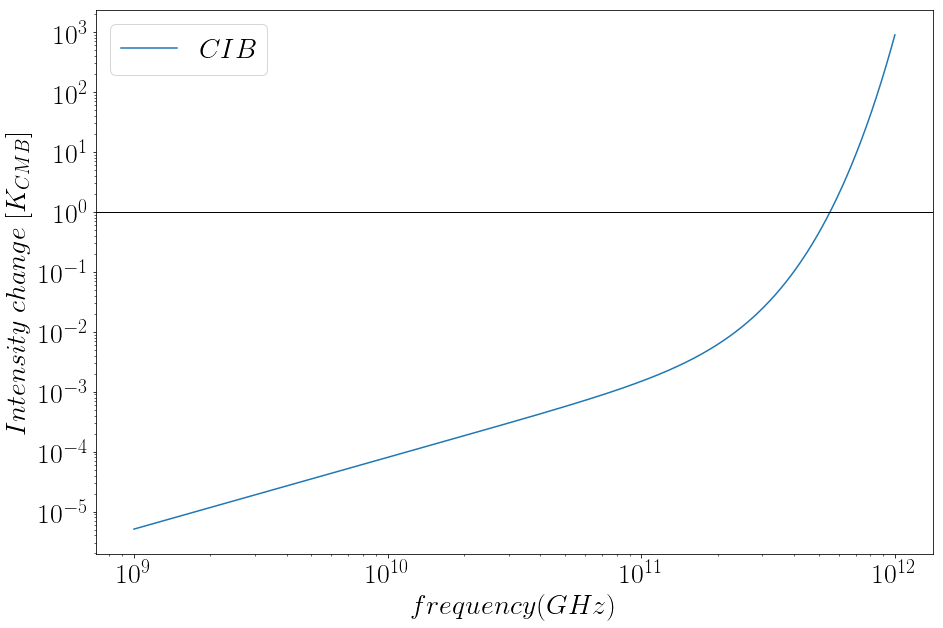

In [15]:
C=np.arange(1,1000)*1e9
D = D_I_CIB(x=C,A=15,b=1.2,T_CIB=24,MJy=False)

fig, ax = plt.subplots()
 
ax.plot(C,D,label='$CIB$') 

ax.axhline(color='black', lw=1,y=1)
#ax.set_title(fig_title,fontsize=28)
ax.set_xlabel('$frequency (GHz)$',fontsize=28)
ax.set_ylabel('$Intensity$ $change$ $[K_{CMB}]$',fontsize=28) 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale('log')
plt.yscale('log')
plt.legend(fontsize=28)
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

###### About the mixing vectors : 

The missing vector is composed of the intensity or temperature variation $\Delta I_{\nu}$ or $\Delta T$ at a given frequency, for all the frequencies we are using in the ILC or CILC method. This is used to compute the final weights of the ILC and retrieve and/or surpress the signal. 

In [16]:
def mixing_vector_tSZ(dic_freq,MJy=False):
    
    """
    Function which compute the multiplying vector to transform a y-map into a tSZ(f). 

    Parameters
    ----------
    
    dic_freq : dic
        Dictonary containing the frequencies we want to get a tSZ map of.  
    MJy : bool 
        If False return the temperature of change of the tSZ, if True the intensity change. 
        
    Returns
    -------
    array
        Array contaning the multiplying vector. 

    """       
    
    #Initilisation : 
    freq = np.arange(1,1000)*10**9  
    mix_vect = []
    
    # Compute the spectral shape of tSZ : 
    Delta_I = D_I_tSZ(freq,1,MJy=MJy)

    #For each frequency channel, compute Delta_I : 
    for i in range(len(dic_freq)):
        
        mix_vect.append(Delta_I[dic_freq[i]])
        
    #Give feeback to the operator :    
    print('The mixing vector of tSZ is : ',mix_vect)

    return mix_vect

In [17]:
def mixing_vector_CMB(dic_freq,MJy=False):
    
    """
    Function which compute the multiplying vector to transform a y-map into a tSZ(f). 

    Parameters
    ----------
    
    dic_freq : dic
        Dictonary containing the frequencies we want to get a tSZ map of.  
    MJy : bool 
        If False return the temperature of change of the CMB, if True the intensity change.
        
    Returns
    -------
    array
        Array contaning the multiplying vector. 

    """       
    
    #Initilisation : 
    freq = np.arange(1,1000)*1e9
    mix_vect = []
    
    if MJy == True: 
    
        # Compute the spectral shape of CMB : 
        Delta_I = D_I_CMB(freq)

        #For each frequency channel, compute Delta_I : 
        for i in range(len(dic_freq)):

            mix_vect.append(Delta_I[dic_freq[i]])
    else: 
        
        mix_vect = [1]*len(dic_freq)
        
    #Give feeback to the operator :    
    print('The mixing vector of CMB is : ',mix_vect)

    return mix_vect

In [18]:
def mixing_vector_CIB(dic_freq,A=1,b=1.2,T_CIB=24,MJy=False):
    
    """
    Function which compute the mixing vector of CIB. 

    Parameters
    ----------
    
    dic_freq : dic
        Dictonary containing the frequencies we want to get a tSZ map of. 
    A : float 
        Normalisation of the CIB power spectrum. By default A=1.
    b : float 
        By default b=1.2
    T_CIB : float
        By default T_CIB=24 Kelvin.
    MJy : bool 
        If False return the temperature of change of the tSZ, if True the intensity change. 
        
    Returns
    -------
    array
        Array contaning the multiplying vector. 

    """       
    
    #Initilisation : 
    freq = np.arange(1,1000)*10**9  
    mix_vect = []
    
    # Compute the spectral shape of tSZ : 
    Delta_I = D_I_CIB(freq,A=A,b=b,T_CIB=T_CIB,MJy=MJy)

    #For each frequency channel, compute Delta_I : 
    for i in range(len(dic_freq)):
        
        mix_vect.append(Delta_I[dic_freq[i]])
        
    #Give feeback to the operator :    
    print('The mixing vector of CIB is : ',mix_vect)

    return mix_vect

###### About ILC weights : 

We suppose our map of the sky can be express in this way : 

$x_{i}(p)=a_{i}s(p)+n_{i}(p)$ 

where x is the total map at a frequency i and a pixel p. a is the mixing vector of the signal of interest s and n all the other astrophysical components and the noise. 

In a case where we want to retrieve tSZ a is the mixing vector of tSZ. we want : 

$\overrightarrow \omega ^{T} \overrightarrow x(p)= \overrightarrow \omega ^{T} \overrightarrow a s(p) + \overrightarrow \omega ^{T} n(p)$

with $ \overrightarrow \omega ^{T} \overrightarrow a = 1$  where $\overrightarrow  \omega $ is the ILC weight. The signal we want is given by : $s = \overrightarrow \omega \overrightarrow x$

The weights are given by : 

$\overrightarrow \omega = \frac{R^{-1}\overrightarrow a}{\overrightarrow a^{t}R^{-1}\overrightarrow a}$

In [19]:
def ILC_weights(mix_vect,data,cov_matrix,k,nside_tess):   
    
        
    """
    Function which compute the weights used by the ILC and do the ILC.

    Parameters
    ----------    
    mix_vect : list 
        List containing all the values of the mixing vector. 
    data : array 
        Array containing all the maps we want to apply the ILC on. 
    cov_matrix : array 
        Array containing the covariance matrix. 
    k : int 
        field k, when sky is divided into fields, we apply the CILC on each of the patches separatly.
    nside_tess : int 
        the number of pixels generated by this nside is used to separated the maps into fields.
        I recommend nside_tess = 4.If nside_tess = 0 then compute the ILC ove the full non-separated sky.

    
    Returns
    -------
    array
        Cotaining the Compton-y map. 

    """ 
        
    inv_cov = np.linalg.inv(cov_matrix) #Take the inverse of the covariance matrix. 
    ILC_weight = (inv_cov @ mix_vect) / (np.transpose(mix_vect) @ inv_cov @ mix_vect) #Compute the weights
    y=0  # Initialisation of the y map. 
    print('original ILC weights',ILC_weight)
         
            
    for i in range(0,len(mix_vect)):
            
        if nside_tess == 0:
                
            map_Ti = data[i]
                
        else:
                
            map_Ti = data[:,k,i]
                
        y = y + ILC_weight[i] * map_Ti  
        
    print('Sum of the ILC weights : ',sum(mix_vect*ILC_weight))

    return y,ILC_weight

###### About the CILC : 

We suppose our map of the sky can be express in this way : 

$x_{i}(p)=a_{i}s(p)+b_{i}y(p)+n_{i}(p)$ 

where x is the total map at a frequency i and a pixel p. a is the mixing vector of the signal s, b the mixing vector or the signal y and n all the other astrophysical components and the noise. 

In a case where we want to minize tSZ and get back a tSZ free CMB, a is the mixing vector of CMB and b the one of tSZ. we want : 

$\overrightarrow \omega ^{T} \overrightarrow x(p)= \overrightarrow \omega ^{T} \overrightarrow a s(p) + \overrightarrow \omega ^{T} \overrightarrow b y(p) + \overrightarrow \omega ^{T} n(p)$

with $ \overrightarrow \omega ^{T} \overrightarrow a = 1$ and $\overrightarrow  \omega ^{T} \overrightarrow b = 0 $ where $\overrightarrow  \omega $ is the CILC weight. The signal we want is given by : $s = \overrightarrow \omega \overrightarrow x$

The weights are given by : 

$\overrightarrow \omega = \frac{R^{-1}\overrightarrow a \overrightarrow b^{t}R^{-1}\overrightarrow b - R^{-1}\overrightarrow b \overrightarrow b^{t}R^{-1}\overrightarrow a}{(\overrightarrow b^{t}R^{-1}\overrightarrow b)(\overrightarrow a^{t}R^{-1}\overrightarrow a)-(\overrightarrow b^{t}R^{-1}\overrightarrow a)^{2}}$

In [20]:
def CILC_weights(mix_vect_b,mix_vect_a,data,cov_matrix,k,nside_tess):   
    
        
    """
    Function which compute the weights used by the ILC and do the ILC.

    Parameters
    ----------    
    mix_vect_b : list 
        List containing all the values of the mixing vector of the signal we want to cancel. 
    mix_vect_a : list 
        List containing all the values of the mixing vector of the signal we want to get back.
    data : array 
        Array containing all the maps we want to apply the CILC on. 
    cov_matrix : array 
        Array containing the covariance matrix. 
    k : int 
        field k, when sky is divided into fields, we apply the CILC on each of the patches separatly.
    nside_tess : int 
        the number of pixels generated by this nside is used to separated the maps into fields.
        I recommend nside_tess = 4.
        
    Returns
    -------
    array
        Containing the CMB map. 

    """ 

    #Compute the weight of the ILC : 
    inv_cov = np.linalg.inv(cov_matrix) #Take the inverse of the covariance matrix. 
    p1 = (inv_cov  @ mix_vect_a) * (np.transpose(mix_vect_b) @ inv_cov @ mix_vect_b)
    p2 = (inv_cov  @ mix_vect_b) *  (np.transpose(mix_vect_b) @ inv_cov @ mix_vect_a)
    p3 = (np.transpose(mix_vect_b) @ inv_cov  @ mix_vect_b) * (np.transpose(mix_vect_a) @ inv_cov  @ mix_vect_a)
    p4 = (np.transpose(mix_vect_b) @ inv_cov  @ mix_vect_a)**2
    
    CILC_weight = (p1 - p2) / (p3 - p4)
    
    y=0  # Initialisation of the y map. 
    
    #Compute y map : 
    for i in range(0,len(mix_vect_a)): #Go through all the frequencies.
        
        if nside_tess == 0: 
            map_Ti = data[i]
        else: 
        
            map_Ti = data[:,k,i]
        y = y + CILC_weight[i] * map_Ti  

    return y,CILC_weight

###### Main code :

This is the main code, you can use it like a black box, you just need to put in the data and this will call of the functions one by one to perform and ILC or CILC. 

One last thing that need to be done, is to remove the ILC bias. Different approach can be used to do that. The easiest one is to take the median of each field and substract it. Another way is to fit a Gaussian to the pixel histogram of each field, take its mean and remove it from each field.

In [21]:
def All_sky_ILC(dic_freq,maps_array,nside_map,nside_tess,wt_reso,dic_reso,median,gauss,
                CILC,mask,mix_vec_min,mix_vec_max):
    
    """
    Code which perform all the steps of an ILC or CILC. 

    Parameters
    ----------    
    dic_freq : dictonary
        Dictonary containing all the frequencies of the map we want to apply the ILC or CILC on. 
    maps_array : arrray 
        Array containing all the maps we want to apply the ILC on. 
    nside_map : int 
        Nside of the all the maps we want to apply the ILC on. 
    nside_tess : int 
        Nside that define the number of field we will separate the all sky map in. To apply the ILC or CILC
        on each of this field separatly. I recommend nside_tess = 4.
    wt_reso : float 
        Desired resolution of all the maps in arcmin. The maps will all the smoothed to this resolution. 
    dic_reso : dictonary 
        Dictonary contaning all the resolution of each of the maps we want to apply the ILC or CILC on.
    median : bool 
        If True will remove the ILC/CILC offset by substracing the median of each field to itself. 
    gauss : bool 
        If True will remove the offset of the ILC/CILC byt fitting a gaussian to the pixel histogran
        and susbtracting the mean of this gaussian to each field,         
    CILC : bool 
        If True the code will perform a CILC instead of and ILC. 
    mask : array 
        Array containing the mask if data are masked. 
    mix_vec_min : array 
        Array containing the mixing vector of the signal we want to minimize. In case CILC=False, this can 
        be any array, it does not matter. 
    mix_vec_max : array 
        Array containing the mixing vector of the signal we want to maximize. In case CILC=False, this is the
        signal we want to retrieve with the ILC. 
    
    Returns
    -------
    array
        Cotaining the Compton-y map. 

    """ 
    
    if nside_tess == 0:
        
        Cube_map = mergemaps(maps_array=maps_array,wt_reso=wt_reso,dic_reso=dic_reso)
        
        if mask is not None: 
            
            Cube_map *= mask
            
        else: 
            
            Cube_map = Cube_map  
            
        cov_mat = covcorr_matrix(Cube_map,rowvar=True,mask=mask,dic_freq=dic_freq)
        
        if CILC == False: 
                    
            fmap_f = ILC_weights(mix_vect=mix_vec_max,data=Cube_map,cov_matrix=cov_mat[0],k=0,
                               nside_tess=nside_tess)
            fmap = fmap_f[0]
            wmap = fmap_f[1]
            
            offset = np.median(fmap) 
            fmap = fmap - offset
            
            if mask is not None: 
                
                fmap *= mask
                
            else: 
                
                fmap = fmap
        
        else: 
            
            fmap_f = CILC_weights(mix_vect_b=mix_vec_min,mix_vect_a=mix_vec_max,data=Cube_map,
                                cov_matrix=cov_mat[0],k=0,nside_tess=nside_tess)
            fmap = fmap_f[0]
            wmap = fmap_f[1]
            
            offset = np.median(fmap)
            fmap = fmap - offset
            
            if mask is not None: 
                
                fmap *= mask
                
            else: 
                
                fmap = fmap
    else:

        nfields = hp.nside2npix(nside_tess) 
        npix = hp.nside2npix(nside_map)
        It = int(npix/nfields)
            
        #Create cube : 
        Cube_map = map2fields(maps_array=maps_array,It=It,nfields=nfields,wt_reso=wt_reso,dic_reso=dic_reso,
                                  median=median,gauss=gauss,mask=mask,dic_freq=dic_freq)
        wmap = np.zeros((nfields,len(dic_freq)))
        fmap = np.zeros(npix)
        
        l=0

        for i in range(0,npix,It):
                
            cov_mat = covcorr_matrix(Cube_map[:,l,:],rowvar=False,mask=mask,dic_freq=dic_freq)
            
            if  CILC == False: 
            
                y_f = ILC_weights(mix_vect=mix_vec_max,data=Cube_map,cov_matrix=cov_mat[0],k=l,
                                nside_tess=nside_tess)  
                y = y_f[0]
                ib = int(i/It)
                wmap[ib,:]=y_f[1]
                
                if mask is not None: 
                    
                    not_masked = np.where(y[:] != 0)[0]
                    data = y[not_masked]
                    offset = np.nanmedian(data)
                    y[not_masked] = data - offset
                
                else: 
                
                    offset = np.median(y)
                    y = y - offset 
                    
                fmap[i:i+It]= y 
                l=l+1
                
                
            else:
                              
                compo_f = CILC_weights(mix_vect_b=mix_vec_min,mix_vect_a=mix_vec_max,data=Cube_map,
                                     cov_matrix=cov_mat[0],k=l,nside_tess=nside_tess)
                compo = compo_f[0]
                ib = int(i/It)
                wmap[ib,:]=compo_f[1]
                
                if mask is not None: 
                    
                    not_masked = np.where(compo[:] != 0)[0]
                    data = compo[not_masked]
                    offset = np.nanmedian(data)
                    compo[not_masked] = data - offset
                    
                else: 
                    
                    offset = np.median(compo)
                    compo = compo - offset 
                    
                fmap[i:i+It] = compo 
                l=l+1
                    
                
    return fmap,wmap

In [22]:
def weight_maps(data,nside,nside_tess,dic_freq,mask):  
    
    """
    Code to compute the ILC weights maps. 

    Parameters
    ----------    
    data : array 
        Array containing the weights for each frequency map.
    nside : int 
        Nside of the maps we applied the ILC/CILC on. 
    nside_tess : int 
        Nside that define the number of field we will separate the all sky map in. To apply the ILC or CILC
        on each of this field separatly. I recommend nside_tess = 4.
    dic_freq : dictonary 
        Dictonary contaning all the frequencies of the maps we want to apply the ILC or CILC on.
    mask : array 
        Array containing the mask if data are masked. 
    
    Returns
    -------
    images
        return Images of the weights maps. 

    """ 
    
    for j in range(len(dic_freq)): 

        npix = hp.nside2npix(nside)
        nfields=hp.nside2npix(nside_tess)
        It = int(npix/nfields)
        weight_map = np.zeros(npix)

        for i in range(0,nfields): 
    
            if i==0: 
        
                weight_map[0:It]=data[:,j][i]*np.ones(It)
        
            else : 
        
                weight_map[i*It:i*It+It]=data[:,j][i]*np.ones(It)
    
        weight_map[np.isnan(weight_map)] = 0
        mask2 = hp.pixelfunc.reorder(mask, r2n = True)
        weight_map = weight_map*mask2

        hp.mollview(map=weight_map, coord=None, unit='$\emptyset$', xsize=2000, nest=True, cbar=True, cmap=cm.bwr,
            norm=None,return_projected_map=True) 
        
    plt.show()

In [23]:
def weight_histo(data,dic_freq): 
    
    """
    Code that return the medians values of the weights for each frequency map. 

    Parameters
    ----------  
    data : array 
        Array containing the weight maps.
    
    Returns
    -------
    array
        Array containing the medians of the weights for each frequency map. 

    """ 

    m_weights = []
    for i in range(len(dic_freq)): 
    
        x = data[:,i]
        x = x[np.logical_not(np.isnan(x))]
        m_weights.append(np.median(x)) 
    
    return m_weights

# Example on Planck datas : 

## read Planck data : 

In [38]:
maps_100 = hp.read_map(data_path+'HFI_SkyMap_100_2048_R2.02_full_conv.fits', nest=False, partial=False, hdu=1)
maps_143 = hp.read_map(data_path+'HFI_SkyMap_143_2048_R2.02_full_conv.fits', nest=False, partial=False, hdu=1)
maps_217 = hp.read_map(data_path+'HFI_SkyMap_217_2048_R2.02_full_conv.fits', nest=False, partial=False, hdu=1)
maps_353 = hp.read_map(data_path+'HFI_SkyMap_353_2048_R2.02_full_conv.fits', nest=False, partial=False, hdu=1)
maps_545 = hp.read_map(data_path+'HFI_SkyMap_545_2048_R2.02_full.fits', nest=False, partial=False, hdu=1) 
maps_857 = hp.read_map(data_path+'HFI_SkyMap_857_2048_R2.02_full.fits', nest=False, partial=False, hdu=1)

NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/users/mcharmetant/anaconda3/lib/python3.6/site-packages/healpy/fitsfunc.py:367: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 2048
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [39]:
maps_array = [maps_100,maps_143,maps_217,maps_353,maps_545,maps_857]

In [40]:
mask = sky.return_mask('Dust', nside_out = 2048, coord = 'G')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## ILC giving a Compton-y map : 

In [41]:
Compton_y = All_sky_ILC(dic_freq=dic_freq,maps_array=maps_array,
                    nside_map=2048,nside_tess=4,wt_reso=9.66,dic_reso=dic_reso,median=True,
                    gauss=False,CILC=False,mask=mask,mix_vec_min=mixing_vector_tSZ(dic_freq,MJy=True),
                    mix_vec_max=mixing_vector_tSZ(dic_freq,MJy=True))

Compton_y[0][np.isnan(Compton_y[0])] = 0

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-990.0884319235898, -1072.2978560598774, 9.960562084653768, 1814.0534105230506, 865.2549779151947, 42.90811289137716]
Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-990.0884319235898, -1072.2978560598774, 9.960562084653768, 1814.0534105230506, 865.2549779151947, 42.90811289137716]
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.701281 arcmin (0.000786 rad) 
-> fwhm is 6.361030 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 3.507388 arcmin (0.001020 rad) 
-> fwhm is 8.259268 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 3.545245 arcmin (0.001031 rad) 
-> fwhm is 8.348413 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 3.550175 arcmin (0.001033 rad) 
-> fwhm is 8.3600

/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:390: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/core/_methods.py:154: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Degrees of freedom <= 0 for slice
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/users/mcharmetant/.local/lib/python3.6/site-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/users/mcharmetant/.

original ILC weights [nan nan nan nan nan nan]
Sum of the ILC weights :  nan
original ILC weights [-1.48268454e-05 -6.99613131e-04  4.52446570e-04  1.73587360e-04
 -9.78593855e-05  9.23852929e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.55712870e-05 -6.83192828e-04  4.32835471e-04  1.83178037e-04
 -9.82185148e-05  8.73670589e-06]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-2.37409626e-05 -6.10307867e-04  3.55596558e-04  2.29524472e-04
 -1.13602353e-04  1.03928769e-05]
Sum of the ILC weights :  1.0
original ILC weights [-1.41253770e-05 -6.77334394e-04  4.24506825e-04  1.87432074e-04
 -9.80789716e-05  7.77492351e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.10067128e-05 -6.98347022e-04  4.45977752e-04  1.77063320e-04
 -9.91581681e-05  9.76404638e-06]
Sum of the ILC weights :  0.9999999999999997
original ILC weights [ 8.67323719e-06 -6.09743223e-04  3.32407398e-04  2.41276226e-04
 -9.99463609e-05  5.6185839

Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.22946732e-05 -6.73909459e-04  4.18659447e-04  1.86160402e-04
 -8.89034742e-05  5.70278574e-06]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-1.24658105e-05 -6.82161504e-04  4.29160437e-04  1.89371712e-04
 -1.06436154e-04  1.08781247e-05]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.29607563e-05 -6.71026749e-04  4.17371312e-04  1.90216239e-04
 -9.46744455e-05  7.57492389e-06]
Sum of the ILC weights :  1.0
original ILC weights [-1.08378942e-05 -6.67098708e-04  4.09587650e-04  1.98826604e-04
 -1.05472319e-04  1.02465206e-05]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-1.32509306e-05 -6.99077452e-04  4.45609811e-04  1.80889522e-04
 -1.10809722e-04  1.30054319e-05]
Sum of the ILC weights :  1.0
original ILC weights [ 4.67058150e-05 -3.35231268e-04 -8.73669490e-06  4.43606367e-04
 -1.36460559e-04  4.88658708e-06]
Sum of the ILC weights :  1.0
original I

Sum of the ILC weights :  0.9999999999999999
original ILC weights [-1.23368983e-05 -6.78741361e-04  4.24195214e-04  1.90241889e-04
 -1.03780423e-04  1.01339898e-05]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.26568340e-05 -6.75554441e-04  4.24214063e-04  1.87132549e-04
 -9.34853653e-05  6.24275922e-06]
Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.17076390e-05 -6.76944591e-04  4.23135771e-04  1.87529943e-04
 -9.49836324e-05  7.06687046e-06]
Sum of the ILC weights :  1.0
original ILC weights [-8.04565770e-06 -6.64465008e-04  4.08103445e-04  1.94898356e-04
 -9.05005962e-05  5.00625562e-06]
Sum of the ILC weights :  1.0
original ILC weights [-8.46475258e-06 -6.66035933e-04  4.08274842e-04  1.97772749e-04
 -9.90886073e-05  7.69498316e-06]
Sum of the ILC weights :  1.0
original ILC weights [-1.40573112e-05 -6.90125017e-04  4.39565478e-04  1.78379632e-04
 -9.50690592e-05  8.22501326e-06]
Sum of the ILC weights :  1.0000000000000004
original I

Sum of the ILC weights :  1.0000000000000002
original ILC weights [-1.15702103e-05 -6.85440050e-04  4.33560319e-04  1.81969315e-04
 -9.38024185e-05  6.78242637e-06]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-1.26023520e-05 -6.77663789e-04  4.25188118e-04  1.87430572e-04
 -9.67459363e-05  7.71065892e-06]
Sum of the ILC weights :  1.0
original ILC weights [-1.09514204e-05 -6.98171909e-04  4.45462446e-04  1.77685797e-04
 -1.00182470e-04  9.87416468e-06]
Sum of the ILC weights :  1.0
original ILC weights [-1.58912114e-05 -6.90001063e-04  4.41016566e-04  1.81390799e-04
 -1.03456492e-04  1.04994061e-05]
Sum of the ILC weights :  0.9999999999999999
original ILC weights [-7.77565952e-06 -6.82880774e-04  4.24896096e-04  1.94336560e-04
 -1.12395381e-04  1.23841005e-05]
Sum of the ILC weights :  1.0000000000000004
original ILC weights [-1.82352932e-05 -7.81520883e-04  5.40655856e-04  1.33711718e-04
 -1.21191757e-04  1.95444658e-05]
Sum of the ILC weights :  1.0
original I

In [42]:
B = weight_histo(data=Compton_y[1],dic_freq=dic_freq)

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


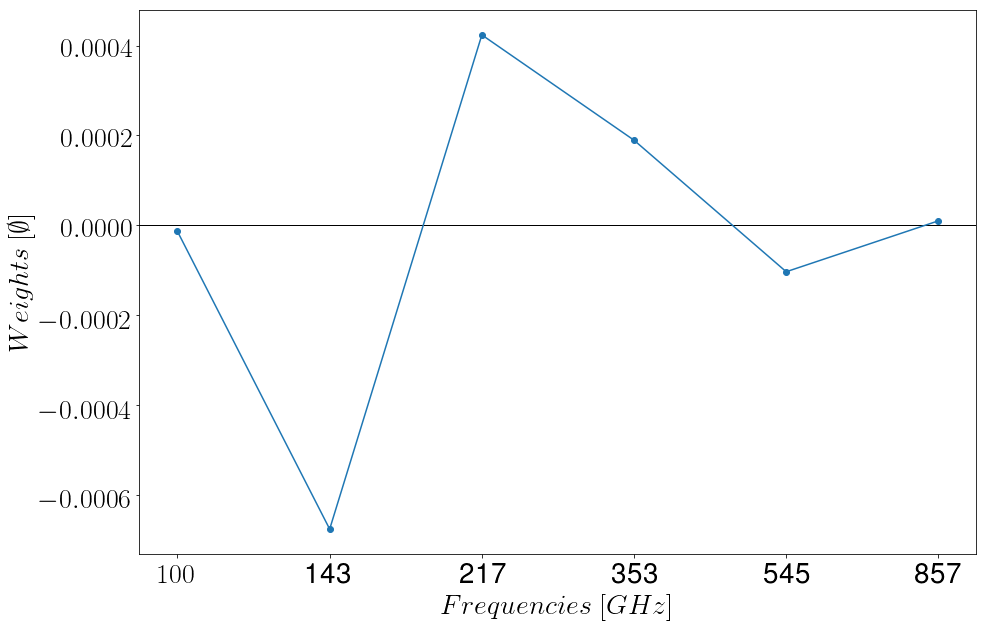

In [43]:
fig, ax = plt.subplots()
ax.axhline(y=0,color='black', lw=1)
plt.rcParams['figure.figsize'] = [15,10]
plt.plot(['$100$','143','217','353','545','857'],B,'o-')
plt.title('',fontsize=28) 
plt.xlabel('$Frequencies$ $[GHz]$',fontsize=28)
plt.ylabel('$Weights$ $[\emptyset]$',fontsize=28) #l(l+1)/2\pi 
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.savefig('/users/mcharmetant/Desktop/Pictures/SO/' + 'test' + '.png') 
plt.show()

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


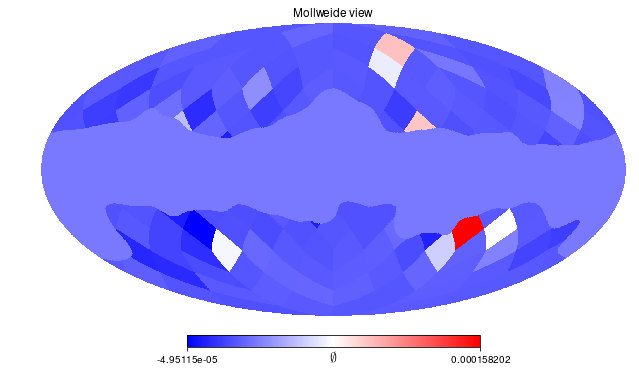

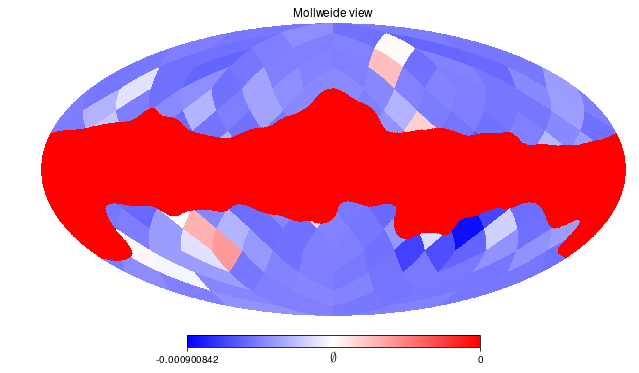

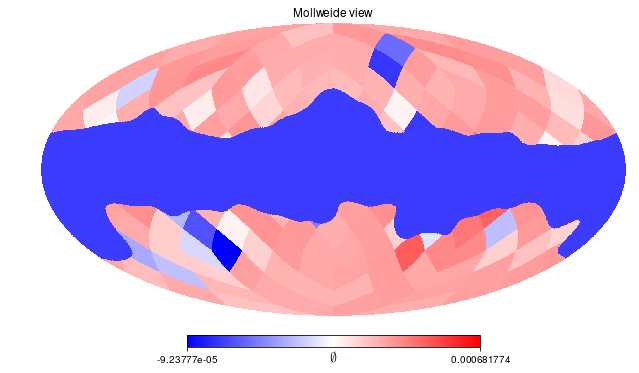

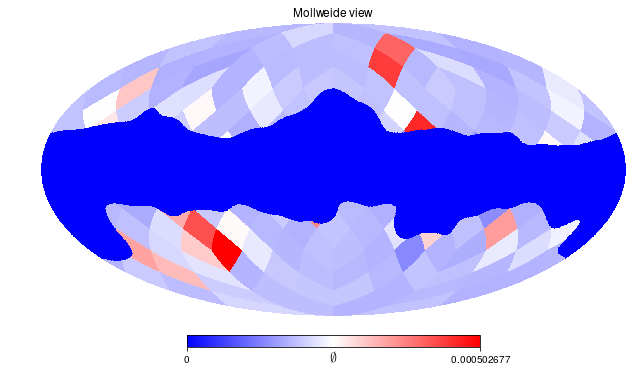

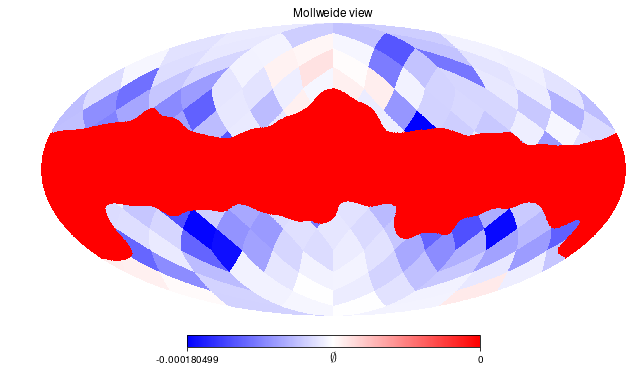

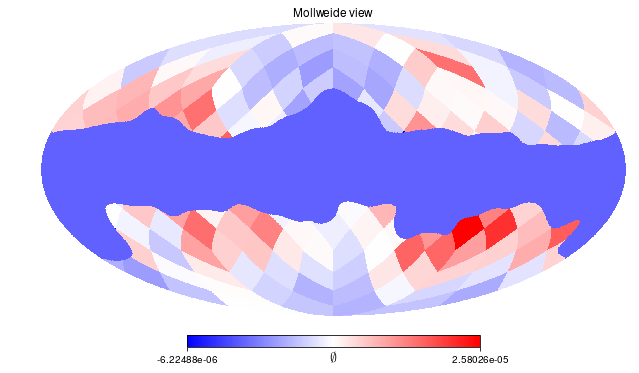

In [44]:
weight_maps(data=Compton_y[1],nside=2048,nside_tess=4,dic_freq=dic_freq,mask=mask)

### Cutout around Coma cluster :  

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


masked_array(
  data=[[-1.73596289e-08, -5.43288136e-07, -5.92410951e-07, ...,
         -1.27366532e-06, -1.59099860e-06, -1.16635784e-06],
        [-1.78909755e-07, -1.78909755e-07, -5.76981410e-07, ...,
          2.35266791e-07, -6.60059618e-07, -5.09735525e-07],
        [-8.04505605e-07, -8.04505605e-07, -9.47270603e-07, ...,
          2.35266791e-07, -1.12473418e-07, -5.09735525e-07],
        ...,
        [-1.75832487e-06, -1.80016224e-07,  5.67458518e-07, ...,
          1.44711563e-06,  7.46640320e-07,  5.42965104e-07],
        [-1.06520727e-06, -1.06520727e-06,  2.93578839e-07, ...,
          1.44711563e-06,  1.83672817e-06,  1.37215968e-06],
        [-1.67999244e-06, -1.20374129e-06, -4.15242914e-07, ...,
          1.89383286e-06,  1.83672817e-06,  2.00900502e-06]],
  mask=False,
  fill_value=-1.6375e+30)

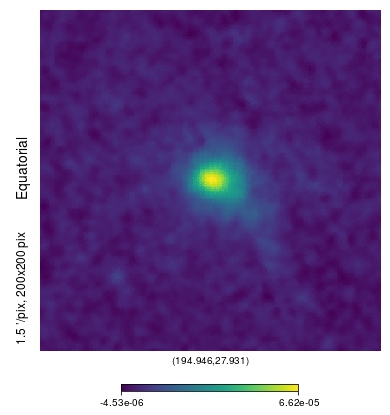

In [45]:
hp.gnomview(Compton_y[0],coord=('G','C'),rot=(194.94583333, 27.93138889),reso=1.5,title='', unit='', xsize=200,
            ysize=200, nest=True, return_projected_map=True) 

## CILC giving a CMB map : 

In [46]:
y_map = All_sky_ILC(dic_freq=dic_freq,maps_array=maps_array,
                    nside_map=2048,nside_tess=4,wt_reso=9.66,dic_reso=dic_reso,median=True,
                    gauss=False,CILC=True,mask=None,mix_vec_min=mixing_vector_tSZ(dic_freq,MJy=True),
                    mix_vec_max=mixing_vector_CMB(dic_freq,MJy=True))

y_map[0][np.isnan(y_map[0])] = 0

Delta I as been computed,I_0 = 270.0626342365431
The mixing vector of tSZ is :  [-990.0884319235898, -1072.2978560598774, 9.960562084653768, 1814.0534105230506, 865.2549779151947, 42.90811289137716]
Delta I as been computed 
The mixing vector of CMB is :  [242.391123960746, 382.6798892288957, 483.6445109436419, 294.769380326228, 56.532752302223855, 1.4172533446599853]
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 2.701281 arcmin (0.000786 rad) 
-> fwhm is 6.361030 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 3.507388 arcmin (0.001020 rad) 
-> fwhm is 8.259268 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 3.545245 arcmin (0.001031 rad) 
-> fwhm is 8.348413 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 3.550175 arcmin (0.001033 rad) 
-> fwhm is 8.360024 arcmin
Sigma is 0.000000

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


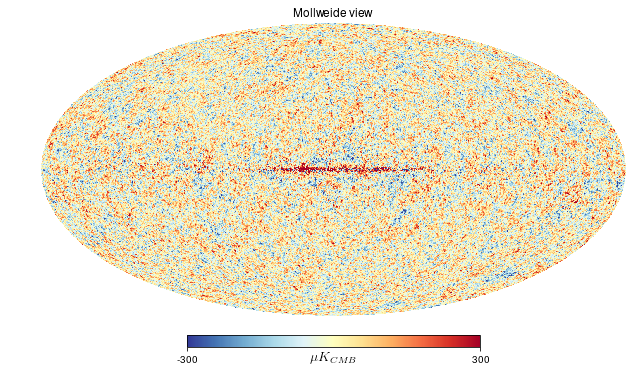

In [49]:
hp.mollview(y_map[0]*1e6, cmap = "RdYlBu_r", min = -300, max = 300,unit='$\mu K_{CMB}$', xsize = 2000, nest=True)

### Cutout around Coma cluster :  

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


masked_array(
  data=[[-1.54980929e-06,  5.84564463e-06, -6.31469479e-06, ...,
          1.17471232e-04,  8.65167968e-05,  8.93146228e-05],
        [ 5.33685701e-06,  5.33685701e-06,  1.17352921e-05, ...,
          7.42555506e-05,  8.30927203e-05,  7.95710622e-05],
        [ 3.30498096e-06,  3.30498096e-06,  1.56036659e-05, ...,
          7.42555506e-05,  5.70915146e-05,  7.95710622e-05],
        ...,
        [-9.29682472e-05, -8.69769659e-05, -9.85193489e-05, ...,
         -8.57271780e-05, -8.69738332e-05, -8.93474267e-05],
        [-6.18656389e-05, -6.18656389e-05, -1.18183986e-04, ...,
         -8.57271780e-05, -8.43771437e-05, -7.41472106e-05],
        [-4.20956199e-05, -6.51284182e-05, -9.19350920e-05, ...,
         -9.60577673e-05, -8.43771437e-05, -6.64513925e-05]],
  mask=False,
  fill_value=-1.6375e+30)

/users/mcharmetant/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


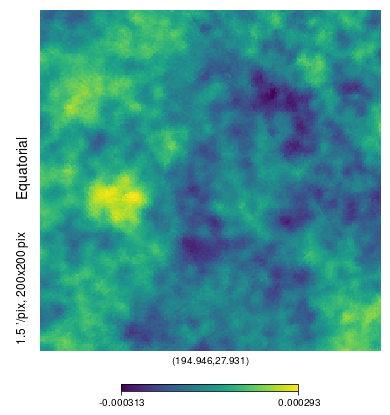

In [51]:
hp.gnomview(y_map[0],coord=('G','C'),rot=(194.94583333, 27.93138889),reso=1.5,title='', unit='', xsize=200,
            ysize=200, nest=True, return_projected_map=True) 